In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.losses import MeanSquaredError

import os
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('dengue_features_train.csv')
labels = pd.read_csv("dengue_labels_train.csv")
test = pd.read_csv("dengue_features_test.csv")
combined = pd.concat([train, test], axis=0, ignore_index=True)
train = train.merge(labels['total_cases'], left_index=True, right_index=True)

### Weekly cases

In [4]:
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [5]:
weekly_cases_sj = train[train['city'] == 'sj'][['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit6 = np.polyfit(weekly_cases_sj.index, weekly_cases_sj['total_cases'], deg = 6)
p6 = np.poly1d(pfit6)

In [6]:
weekly_cases_iq = train[train['city'] == 'iq'][['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit2 = np.polyfit(weekly_cases_iq.index[:-2], weekly_cases_iq['total_cases'][:-2], deg = 2)
p2 = np.poly1d(pfit2)

In [7]:
sj_poly_train = p6(weekly_cases_sj.index)
iq_poly_train = p2(weekly_cases_iq.index)
sj_poly_test = p6(weekly_cases_sj.index)
iq_poly_test = p2(weekly_cases_iq.index)
train['poly_fit'] = 0
for i in (weekly_cases_sj.index):
    mask = (train.city == 'sj') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = sj_poly_train[i-1]
    mask = (test.city == 'sj') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = sj_poly_test[i-1]
    mask = (train.city == 'iq') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = iq_poly_train[i-1]
    mask = (test.city == 'iq') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = iq_poly_test[i-1]

### Splitting up by City

In [8]:
train_sj = train[train['city'] == 'sj']
test_sj = test[test['city']=='sj']
train_iq = train[train['city'] == 'iq'].reset_index().drop('index', axis = 1)
test_iq = test[test['city'] == 'iq'].reset_index().drop('index', axis = 1)

### Data Preprocessing

I added PolynomialFeatures:

Polynomial features allow your linear model to capture non-linear relationships by introducing squares and interaction terms. This can make your model more complex and capable of fitting more complicated data patterns.

For datasets where the relationship between the independent variables and the dependent variable is not purely linear, adding polynomial features can improve the model's accuracy by capturing these non-linear relationships.

In [9]:
numeric_cols = combined.select_dtypes(include=[np.number]).drop(['year', 'weekofyear'], axis = 1).columns.tolist()

In [10]:
best_raw_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 'station_avg_temp_c',
                     'station_min_temp_c', 'poly_fit']

In [11]:
categorical_cols = None

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer


def feature_pipeline(df_train, df_test, numeric_cols, categorical_cols, num_pca = 3):
    
    #Create pipeline for numerical features
            # Interpolate > Impute > add features > scale
        
    df_train.loc[:,numeric_cols].interpolate(inplace = True)
    df_test.loc[:,numeric_cols].interpolate(inplace = True)
    
    num_feature_pipeline = Pipeline([
                                    ("imputer", SimpleImputer(strategy="mean")),
                                    ('features', FeatureUnion([
                                                               ('poly', PolynomialFeatures(degree = 2, interaction_only = False, include_bias = True))])), 
                                    ("scaler", RobustScaler())])
    
    #Fit numerical pipeline to training data
    num_train_pipe_fit = num_feature_pipeline.fit(df_train[numeric_cols], df_train['total_cases'])
    
    if categorical_cols != None:
        enc = OneHotEncoder()
        encfit = enc.fit(df_train[categorical_cols])
        #Construct training features
        num_features_train = num_train_pipe_fit.transform(df_train[numeric_cols])
        cat_features_train = encfit.transform(df_train[categorical_cols]).toarray()
        train_feature_df = pd.DataFrame(np.concatenate((num_features_train, cat_features_train), axis = 1))
        train_feature_df['total_cases'] = df_train['total_cases']

        #Construct test features (with additional columns for submission format) 
        num_features_test = num_train_pipe_fit.transform(df_test[numeric_cols])
        cat_features_test = encfit.transform(df_test[categorical_cols]).toarray()
        test_feature_df = pd.DataFrame(np.concatenate((num_features_test, cat_features_test), axis = 1))
        test_feature_df['city'] = df_test['city']
        test_feature_df['year'] = df_test['year']
        test_feature_df['weekofyear'] = df_test['weekofyear']
    
    else:
        #Construct training features
        num_features_train = num_train_pipe_fit.transform(df_train[numeric_cols])
        train_feature_df = pd.DataFrame(num_features_train)
        train_feature_df['total_cases'] = df_train['total_cases'].values

        #Construct test features (with additional columns for submission format) 
        num_features_test = num_train_pipe_fit.transform(df_test[numeric_cols])
        test_feature_df = pd.DataFrame(num_features_test)
        test_feature_df['city'] = df_test['city']
        test_feature_df['year'] = df_test['year']
        test_feature_df['weekofyear'] = df_test['weekofyear']
    
    return(train_feature_df, test_feature_df)

In [13]:
numeric_cols = best_raw_features

In [14]:
iq_feature_train, iq_feature_test = feature_pipeline(train_iq, test_iq, numeric_cols, categorical_cols)
sj_feature_train, sj_feature_test = feature_pipeline(train_sj, test_sj, numeric_cols, categorical_cols)

### Reducing dataframe to numericalfeatures including weekly_cases

In [15]:
sj_feature_train_new = sj_feature_train.iloc[:, 1:6]
sj_feature_train_new['total_cases'] = sj_feature_train['total_cases']
sj_feature_train = sj_feature_train_new
sj_feature_train.head(5)

,1,2,3,4,5,total_cases
0,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,4
1,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,5
2,0.006304,-0.005017,-0.214395,0.000000,-0.530953,4
3,-0.061121,-0.053519,0.110260,0.227273,-0.510605,3
4,0.144991,0.146063,0.741194,0.500000,-0.479789,6


In [16]:
iq_feature_train_new = iq_feature_train.iloc[:, 1:6]
iq_feature_train_new['total_cases'] = iq_feature_train['total_cases']
iq_feature_train = iq_feature_train_new
iq_feature_train.head(5)

,1,2,3,4,5,total_cases
0,-0.374283,-0.332172,-1.142356,-0.428571,-0.518389,0
1,-0.271416,-0.242713,-0.637306,-0.357143,-0.515560,0
2,-0.146308,-0.107058,-0.738316,-0.428571,-0.506596,0
3,-1.454387,-1.557470,-1.782087,-4.714286,-0.491497,0
4,-0.961599,-0.962053,-0.940336,-1.571429,-0.470264,0


In [17]:
sj_feature_test = sj_feature_test.iloc[:, list(range(1, 6)) + [21, 22, 23]]
sj_feature_test.head(5)

iq_feature_test = iq_feature_test.iloc[:, list(range(1, 6)) + [21, 22, 23]]
iq_feature_test.head(5)

,1,2,3,4,5,city,year,weekofyear
0,0.113640,0.147388,-0.091851,0.142857,-0.518389,iq,2010,26
1,-0.535534,-0.513291,-0.511043,-0.071429,-0.515560,iq,2010,27
2,0.296438,0.300642,-0.586801,0.214286,-0.506596,iq,2010,28
3,-0.985925,-1.125573,-0.637306,-5.071429,-0.491497,iq,2010,29
4,-0.949783,-0.995050,-0.485791,-3.142857,-0.470264,iq,2010,30


### Create lookback feature sets

The function series_to_supervised is a utility for transforming time series data into a format suitable for supervised learning models. By creating lagged (past) and lead (future) versions of each time series variable, it allows to frame a forecasting problem where the goal is to predict future values based on past observations. 

The function:
- takes my list of features and creates two sets of columns: one for the inputs and one for the outputs (predicted cases).
- It gives each column a name that indicates whether it's an input or an output and which day it refers to
- Because I am shifting data, some rows won't have all the necessary information. The function can remove these rows to keep everything neat.

In [18]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    # Determine Number of Variables
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Generate Input Sequence Columns
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Generate Forecast Sequence Columns
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
   
    # Combine and clean up
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [19]:
n_lookback = 20

##### Lookback San Juan Train

In [20]:
# Call function
X_tr_sj_wide = series_to_supervised(sj_feature_train.drop('total_cases', axis = 1), n_lookback, 1)

# Drop current timestep columns (t)
X_tr_sj_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)


# Add total_cases back
X_tr_sj_wide['total_cases'] = sj_feature_train['total_cases']

X_tr_sj_wide.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),var5(t-19),...,var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),total_cases
20,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,...,0.261463,0.477795,0.227273,0.741472,0.746334,0.681254,0.630934,0.727273,0.823792,40
21,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,0.006304,-0.005017,-0.214395,0.000000,-0.530953,...,0.681254,0.630934,0.727273,0.823792,0.407017,0.384111,0.441041,0.500000,0.893902,27
22,0.006304,-0.005017,-0.214395,0.000000,-0.530953,-0.061121,-0.053519,0.110260,0.227273,-0.510605,...,0.384111,0.441041,0.500000,0.893902,0.244210,0.226899,0.483920,0.727273,0.949625,42
23,-0.061121,-0.053519,0.110260,0.227273,-0.510605,0.144991,0.146063,0.741194,0.500000,-0.479789,...,0.226899,0.483920,0.727273,0.949625,0.517199,0.474983,0.667688,0.500000,0.988991,33
24,0.144991,0.146063,0.741194,0.500000,-0.479789,0.146087,0.157770,0.385911,0.500000,-0.438229,...,0.474983,0.667688,0.500000,0.988991,0.644923,0.578118,0.606432,0.727273,1.010317,43


#### Lookback San Juan Test

In [21]:
# Drop 'total_cases' from sj_feature_train
X_test_sj_wide = sj_feature_train.drop(['total_cases'], axis=1).iloc[-n_lookback:, :]

# Concatenate sj_feature_test without 'city', 'weekofyear', and 'year' columns
X_test_sj_wide = pd.concat([X_test_sj_wide, sj_feature_test.drop(['city', 'weekofyear', 'year'], axis=1)], ignore_index=True)

# Reset the index
X_test_sj_wide.reset_index(drop=True, inplace=True)

# Call function
X_test_sj_wide = series_to_supervised(X_test_sj_wide, n_lookback, 1)

# Drop current timestep columns (t)
X_test_sj_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)

# Reset dataframe
X_test_sj_wide = pd.DataFrame(X_test_sj_wide).reset_index(drop = True)
X_test_sj_wide['city'] = 'sj'
X_test_sj_wide['year'] = sj_feature_test['year']
X_test_sj_wide['weekofyear'] = sj_feature_test['weekofyear']

#### Lookback Iquitos Train

In [22]:
# Call function
X_tr_iq_wide = series_to_supervised(iq_feature_train.drop('total_cases', axis = 1), n_lookback, 1)

# Drop current timestep columns (t)
X_tr_iq_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)

# Add total_cases back
X_tr_iq_wide['total_cases'] = iq_feature_train['total_cases']

#### Lookback Iquitos Test

In [23]:
# Drop 'total_cases' from iq_feature_train
X_test_iq_wide = iq_feature_train.drop(['total_cases'], axis=1).iloc[-n_lookback:, :]

# Concatenate iq_feature_test without 'city', 'weekofyear', and 'year' columns
X_test_iq_wide = pd.concat([X_test_iq_wide, iq_feature_test.drop(['city', 'weekofyear', 'year'], axis=1)], ignore_index=True)

# Reset the index
X_test_iq_wide.reset_index(drop=True, inplace=True)

# Call function
X_test_iq_wide = series_to_supervised(X_test_iq_wide, n_lookback, 1)

# Drop current timestep columns (t)
X_test_iq_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis=1, inplace=True)

# Reset dataframe
X_test_iq_wide = pd.DataFrame(X_test_iq_wide).reset_index(drop = True)
X_test_iq_wide['city'] = 'iq'
X_test_iq_wide['year'] = iq_feature_test['year']
X_test_iq_wide['weekofyear'] = iq_feature_test['weekofyear']

### Setting up LSTM model

In [24]:
sj_feature_train = X_tr_sj_wide
iq_feature_train = X_tr_iq_wide
sj_feature_test = X_test_sj_wide
iq_feature_test = X_test_iq_wide

In [25]:
from tensorflow.keras.layers import Dropout

def fit_and_predict_LSTM(train_wide, test_wide, epochs = 200, n_hidden = 25, activation = 'linear', verbose = 0):
    
    values = train_wide.values
    n_train = values.shape[0] - 200
    train = values[:n_train, :]
    val = values[n_train:, :]
    
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_wide.drop(['city', 'year', 'weekofyear'], axis = 1).values
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    model = Sequential()
    model.add(LSTM(n_hidden, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.4))
    model.add(Dense(n_hidden))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(val_X, val_y), verbose=verbose, shuffle=False)
    
    plt.figure(figsize = (7,5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
    
    #build predictions for figure
    test_preds = model.predict(test_X)
    train_X_full = values[:,:-1]
    train_preds = model.predict(train_X_full.reshape((train_X_full.shape[0], 1, train_X_full.shape[1])))
    
    # Calculate MAPE
    mape_metric = MeanAbsolutePercentageError()
    mape_metric.update_state(train_wide['total_cases'], train_preds)
    train_mape = mape_metric.result().numpy()

    # Make plot
    fig, ax = plt.subplots(figsize = (20,10))
    train_error = np.round(mean_absolute_error(train_preds, train_wide['total_cases']),1)
    pd.DataFrame(train_preds).plot(ax = ax)
    pd.DataFrame(train_wide['total_cases']).reset_index(drop = True).plot(ax = ax)
    pd.DataFrame(test_preds).set_index(np.arange(len(train_wide), len(train_wide)+ len(test_preds))).plot(ax = ax)
    
    ax.legend(labels = ['Fitted', 'True', 'Predicted'])
    ax.set_title(f'Mean train error: {train_error}, , MAPE: {train_mape:.2f}%')
    return(model, train_preds, test_preds)

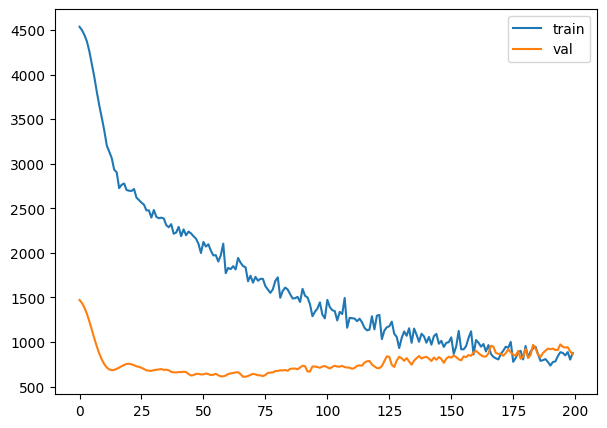

29/29 [==============================] - 0s 463us/step


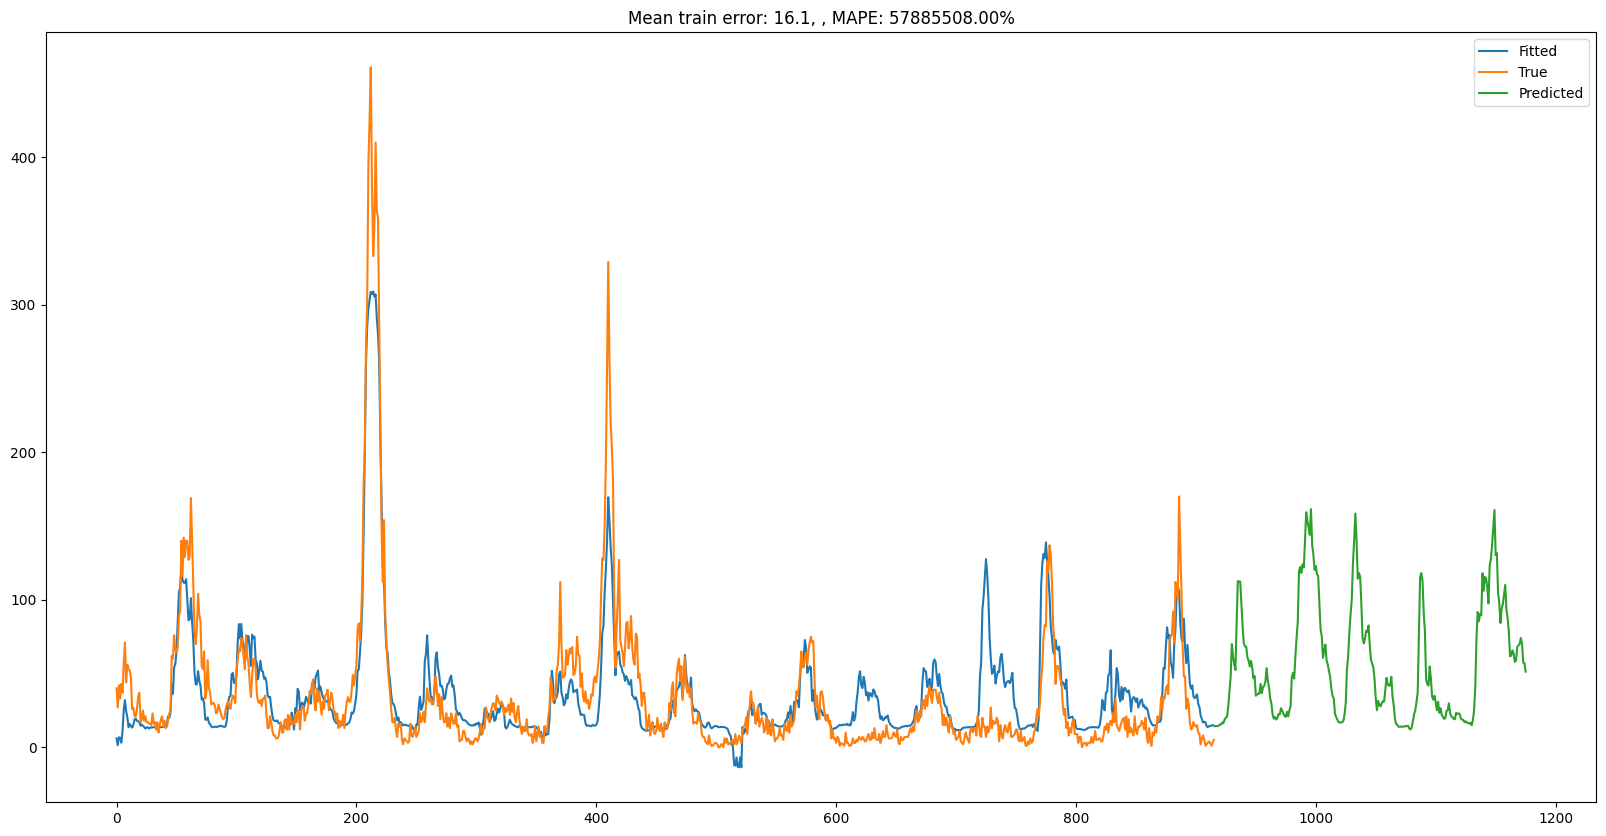

In [26]:
sj_model, sj_train_preds, sj_test_preds = fit_and_predict_LSTM(sj_feature_train, sj_feature_test, epochs = 200, n_hidden = 40, verbose = 0)

In [27]:
output_sj = pd.DataFrame(np.append(sj_train_preds,sj_test_preds))
output_sj["total_cases"] = output_sj.astype(int)
output_sj.drop(columns=[0], inplace=True)

Text(0, 0.5, 'total_cases')

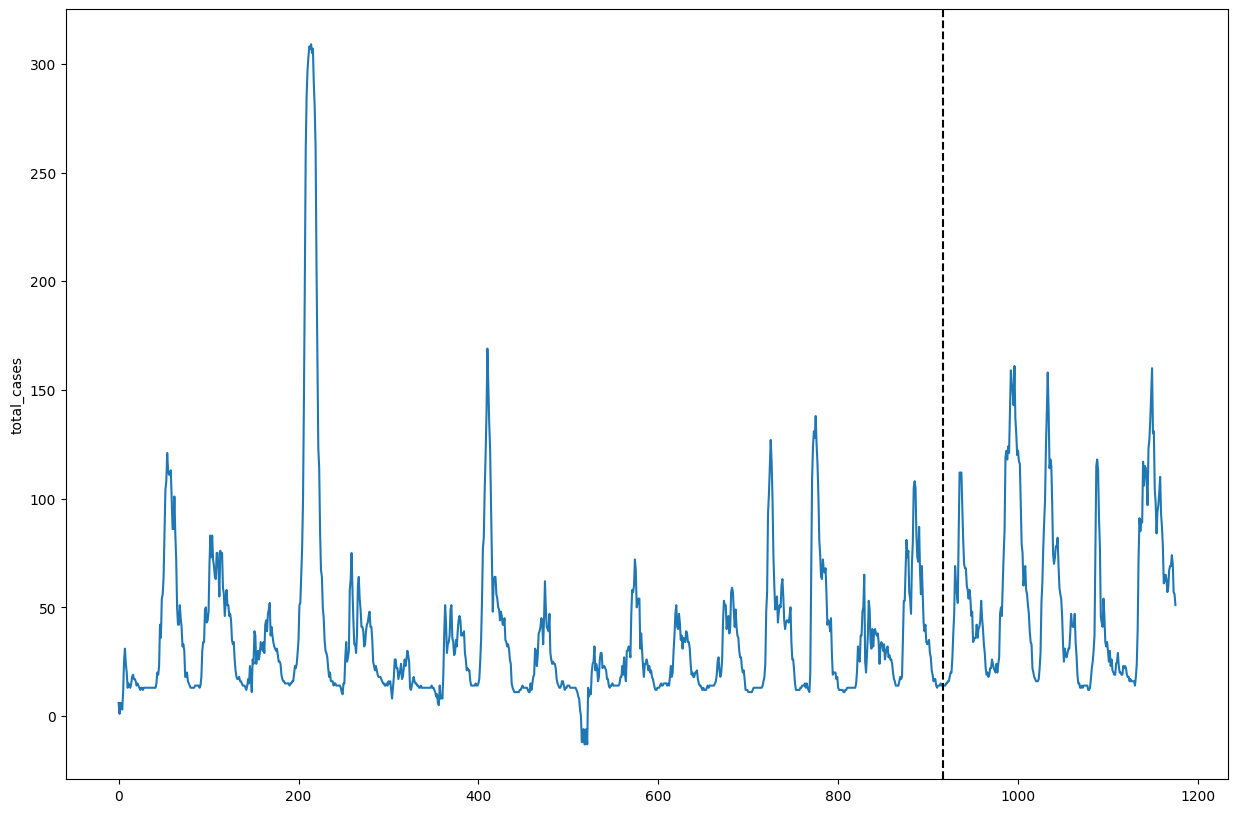

In [28]:
fig, ax = plt.subplots(figsize = (15,10))
output_sj['total_cases'].plot(ax = ax)
ax.axvline(len(sj_train_preds), linestyle = 'dashed', color = 'black')
ax.set_ylabel('total_cases')

Benchmark leaves out first 70 rows - because there have been nearly no Dengue cases

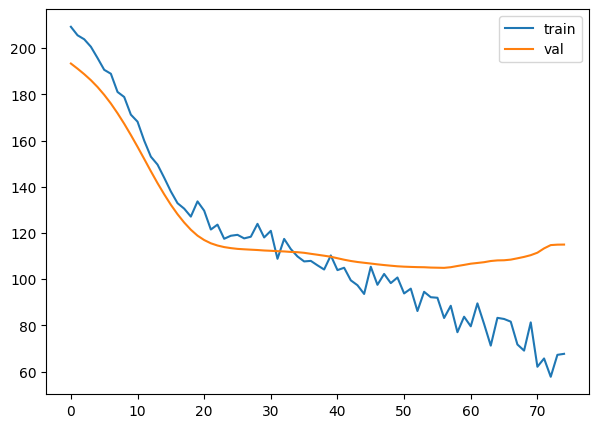

14/14 [==============================] - 0s 397us/step


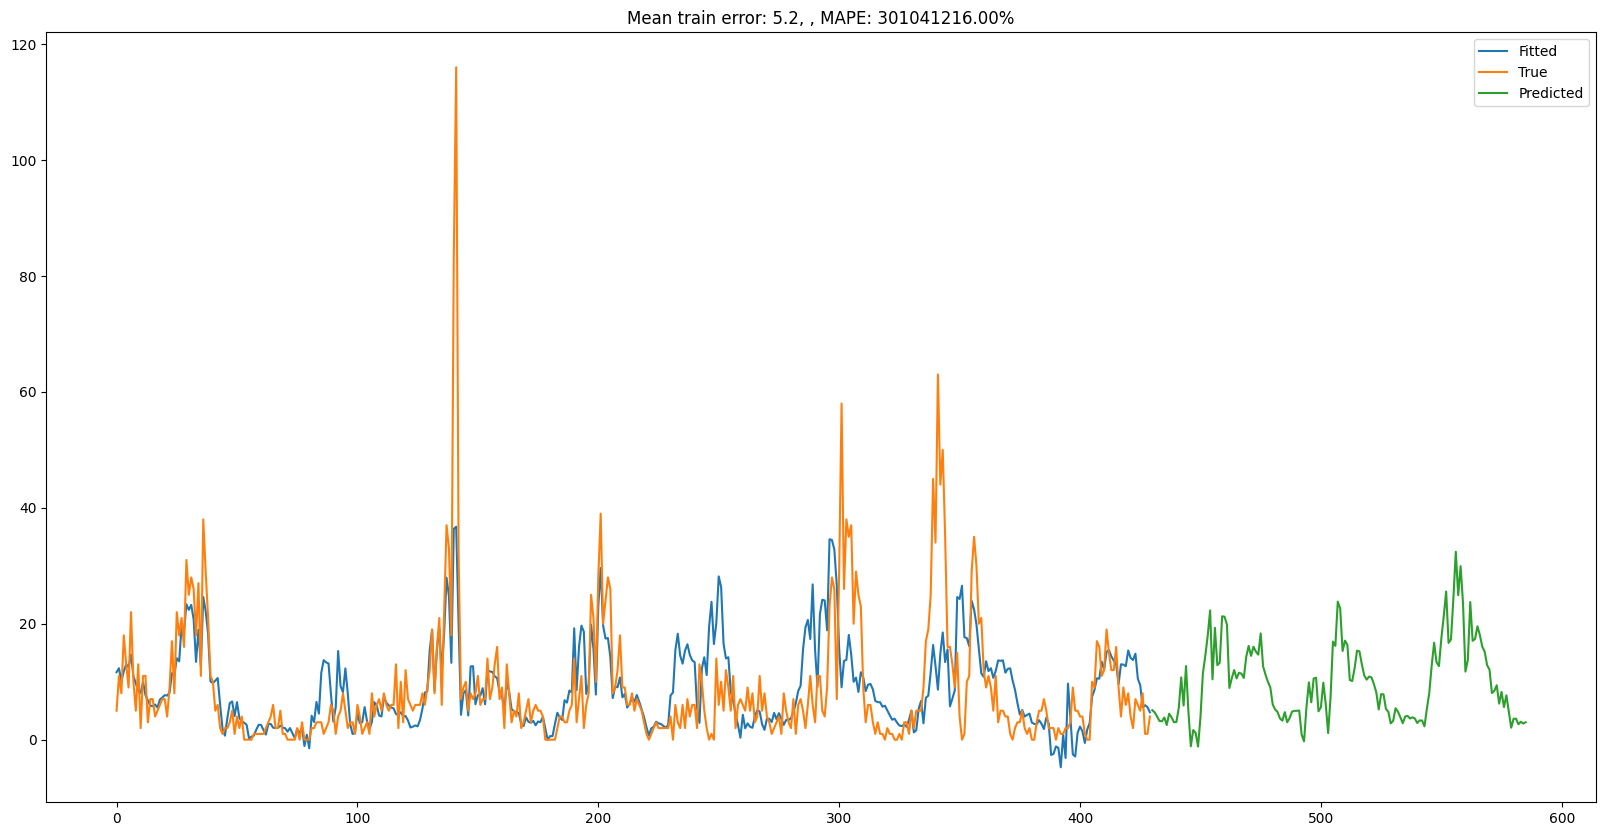

In [29]:
iq_model, iq_train_preds, iq_test_preds = fit_and_predict_LSTM(iq_feature_train.iloc[70:,:], iq_feature_test, epochs = 75, n_hidden = 40, verbose = 0)

In [30]:
iq_train_preds.shape

(430, 1)

In [31]:
iq_feature_train.shape

(500, 101)

In [32]:
output_iq = pd.DataFrame(np.append(iq_train_preds,iq_test_preds))
output_iq["total_cases"] = output_iq.astype(int)
output_iq.drop(columns=[0], inplace=True)

Text(0, 0.5, 'total_cases')

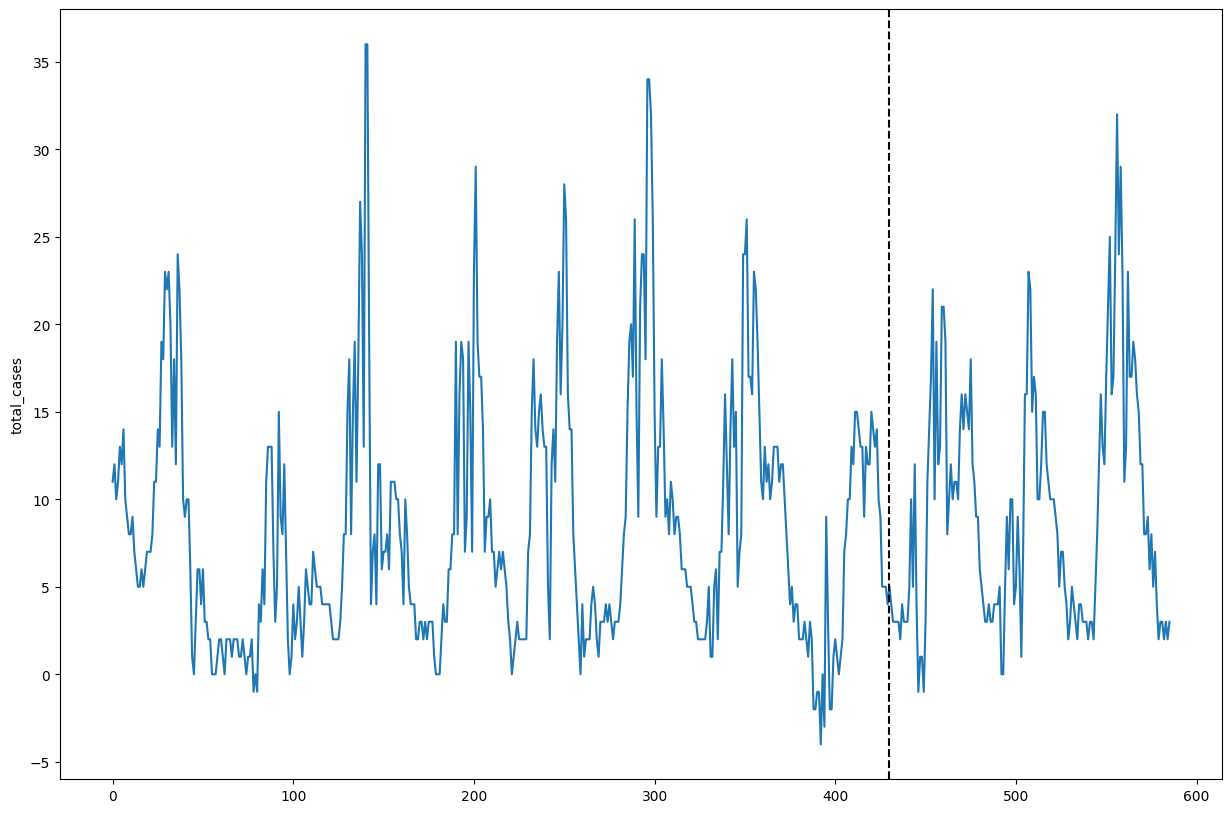

In [33]:
fig, ax = plt.subplots(figsize = (15,10))
output_iq['total_cases'].plot(ax = ax)
ax.axvline(len(iq_train_preds), linestyle = 'dashed', color = 'black')
ax.set_ylabel('total_cases')

## Generating submission file

week_start_date sj 2008-04-29, iq 2010-07-02
iq training date range:  2000-07-01 to 2010-06-25
sj training date range:  1990-04-30 to 2008-04-22

In [34]:
sj_sub = pd.DataFrame(sj_test_preds.astype(int), columns = ['total_cases'])
sj_sub['year'] = sj_feature_test['year']
sj_sub['weekofyear'] = sj_feature_test['weekofyear']
sj_sub['city'] = 'sj'

In [35]:
iq_sub = pd.DataFrame(iq_test_preds.astype(int), columns = ['total_cases'])
iq_sub['year'] = iq_feature_test['year']
iq_sub['weekofyear'] = iq_feature_test['weekofyear']
iq_sub['city'] = 'iq'

In [36]:
sub = pd.concat([sj_sub, iq_sub])[['city', 'year', 'weekofyear', 'total_cases']]

In [37]:
submission = sub.set_index(['city', 'year', 'weekofyear'])
submission.head()

total_cases
city year weekofyear             
sj   2008 18                   14
          19                   14
          20                   14
          21                   14
          22                   15

In [38]:
submission.to_csv("lstm_benchmark.csv")